# Assignment 5 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

You can either go and use a desktop in the big data lab or remote login to one of the machines via [CSIL CPU servers](http://www.sfu.ca/computing/about/support/csil/how-to-remote-access-to-csil.html).

When you're at a machine run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+

(dlenv) sbergner@asb10928u-e04:~/Teaching$ pstree -ls 10843
screenâ”€â”€â”€bashâ”€â”€â”€jupyter-notebooâ”€â”€â”€pythonâ”€â”¬â”€4*[python]
                                         â””â”€26*[{python}]
```

This shows that we have an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3G of GPU memory. Inside a shell window you may use ``who``, ``ps -aux``, or ``pstree -ls <PID>`` to find out who to contact about your shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting and closing the notebook frees up the memory. 

## Set up pytorch in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

As of Tue, Feb 6, the lab has a working pytorch setup in ```/opt/ancaconda3```, e.g. check for yourself by running ```conda list | grep torch```.

However, if there are problems there is an alternative dlenv conda environment for you to use as shown below.

Either you load it directly
```
source activate /usr/shared/CMPT/big-data/tmp_py/dlenv
```
or you prepare
```
cd ~
mkdir -p .conda/envs
ln -s /usr/shared/CMPT/big-data/tmp_py/dlenv .conda/envs
```
and from thereon simply use
```
source activate dlenv
```
### Use our downloaded pre-built models
Also, link the pre-built models that we already downloaded for you (about 1.6G):
```
mkdir -p ~/.torch/models
ln -s /usr/shared/CMPT/big-data/tmp_py/.torch/models/* ~/.torch/models
```

## Learn about Pytorch usage

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

**Here is an example of the training data:**

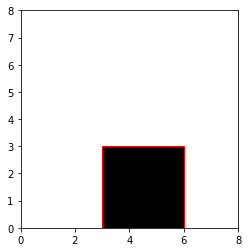

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]
display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [11]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [12]:
model = torch.nn.Sequential(torch.nn.Linear(X.shape[-1],200),\
                            torch.nn.ReLU(),torch.nn.Dropout(p=0.2),torch.nn.Linear(200,y.shape[-1]))

In [13]:
optimizer = torch.optim.Adadelta(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

In [14]:
inputs = Variable(torch.Tensor(train_X))
labels = Variable(torch.Tensor(train_y))

In [15]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(30):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data[0] * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

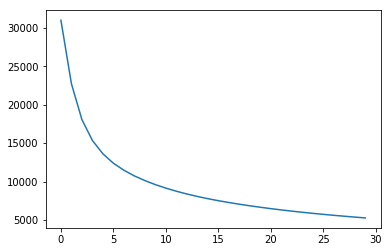

In [16]:
plt.plot(loss_record)

In [17]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.Tensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [18]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.17791300923113207

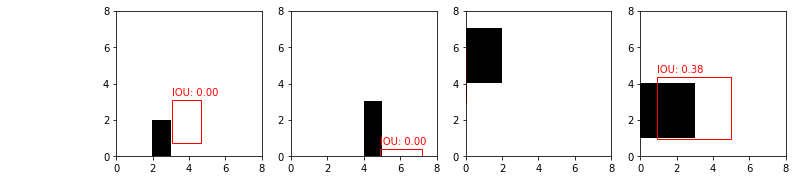

In [19]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you reach an IOU of above 0.6.
You can make the changes that move computation to the GPU directly in the cells above.

In [20]:
model = torch.nn.Sequential(torch.nn.Linear(X.shape[-1],200),\
                            torch.nn.ReLU(),torch.nn.Dropout(p=0.2),torch.nn.Linear(200,y.shape[-1]))
model.cuda()

Sequential(
  (0): Linear(in_features=64, out_features=200)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=200, out_features=4)
)

In [21]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

In [22]:
inputs = Variable(torch.Tensor(train_X).cuda())
labels = Variable(torch.Tensor(train_y).cuda())

In [23]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(2500):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data[0] * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

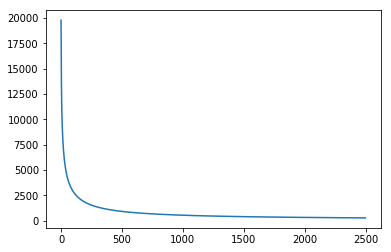

In [25]:
plt.plot(loss_record)

In [26]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.Tensor(test_X).cuda()))
pred_bboxes = pred_y.data * img_size
pred_bboxes=pred_bboxes.cpu()
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [27]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.6796949908321891

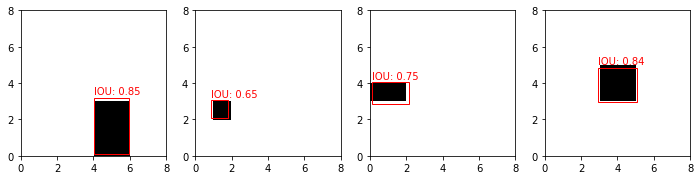

In [28]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

# Task 2: Use a pretrained model

As mentioned in class deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes.

### Hints for step 3

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG19 instead.

Next, print out the new model_conv and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but works similarity. Identify the module that contains the last classification step of the VGG model, which identifies one out of 1000 classes. Change that one into identifying 2 classes only (i.e. the ants and bees that you should start with).

To change the structure of a hypothetical sequential component called ```module_name``` and modify its last layer into a DifferentLayer type, you can use this syntax.

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old model_conv.module_name with the differently structured version.

## Submission

For task 1 add your changes to the cells in this notebook.

For task 2 append the required fields of the the transfer learning tutorial to this notebook and make the required modifications. Ensure that you have clear section headings that show where you undertake which parts of the question.

Save [this notebook](A5-instruction.ipynb) containing all images and upload your submission as one A5.ipynb file.

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/opt/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/opt/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


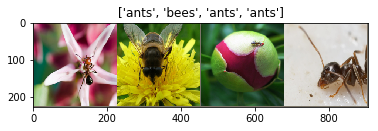

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
#Step 2 - Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.

In [100]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [101]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7004 Acc: 0.6844
val Loss: 0.3797 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.4862 Acc: 0.8115
val Loss: 0.3028 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5120 Acc: 0.7951
val Loss: 0.3168 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5186 Acc: 0.8033
val Loss: 0.3479 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.3778 Acc: 0.8689
val Loss: 0.6584 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.4717 Acc: 0.8443
val Loss: 0.1916 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.6794 Acc: 0.7500
val Loss: 0.6209 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.4412 Acc: 0.8361
val Loss: 0.3509 Acc: 0.8693

Epoch 8/24
----------
train Loss: 0.3622 Acc: 0.8648
val Loss: 0.2890 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.2668 Acc: 0.8893
val Loss: 0.2558 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3316 Acc: 0.8730
val Loss: 0.2385 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2811 Acc: 0.8975
val Loss: 0.2294 Acc: 0.9020

Ep

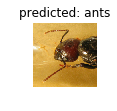

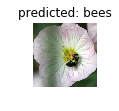

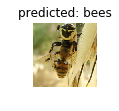

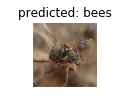

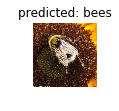

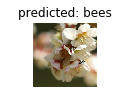

In [102]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [106]:
#Step 3 - Code for VGG 19 and Alexnet
model_conv = torchvision.models.vgg19(pretrained=True)
model_conv.classifier=torch.nn.Sequential(*list(model_conv.classifier.children())[:-1] +
                     [torch.nn.Linear(in_features=4096, out_features=2)])


for param in model_conv.parameters():
    param.requires_grad = True

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv._modules['classifier'][6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [59]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2488 Acc: 0.8975
val Loss: 0.0723 Acc: 0.9804

Epoch 1/24
----------
train Loss: 0.1652 Acc: 0.9344
val Loss: 0.0621 Acc: 0.9739

Epoch 2/24
----------
train Loss: 0.1513 Acc: 0.9549
val Loss: 0.0793 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.1178 Acc: 0.9508
val Loss: 0.0960 Acc: 0.9739

Epoch 4/24
----------
train Loss: 0.2016 Acc: 0.9426
val Loss: 0.0890 Acc: 0.9673

Epoch 5/24
----------
train Loss: 0.1563 Acc: 0.9467
val Loss: 0.1424 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.0961 Acc: 0.9590
val Loss: 0.0821 Acc: 0.9673

Epoch 7/24
----------
train Loss: 0.0710 Acc: 0.9672
val Loss: 0.0827 Acc: 0.9739

Epoch 8/24
----------
train Loss: 0.1707 Acc: 0.9467
val Loss: 0.0835 Acc: 0.9739

Epoch 9/24
----------
train Loss: 0.1137 Acc: 0.9631
val Loss: 0.0863 Acc: 0.9739

Epoch 10/24
----------
train Loss: 0.1169 Acc: 0.9508
val Loss: 0.0851 Acc: 0.9739

Epoch 11/24
----------
train Loss: 0.1521 Acc: 0.9426
val Loss: 0.0855 Acc: 0.9739

Ep

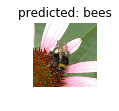

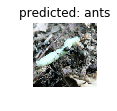

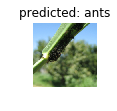

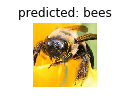

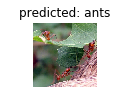

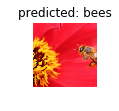

In [60]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [7]:
# For alexnet

model_conv = torchvision.models.alexnet(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
    
model_conv.classifier=nn.Sequential(*list(model_conv.classifier.children())[:-1] +
                     [nn.Linear(in_features=4096, out_features=2)])


if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9102 Acc: 0.7746
val Loss: 0.4727 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.7653 Acc: 0.8770
val Loss: 1.0948 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.7089 Acc: 0.9016
val Loss: 0.8590 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.6088 Acc: 0.8730
val Loss: 1.1684 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.6756 Acc: 0.9098
val Loss: 1.1089 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.6088 Acc: 0.9016
val Loss: 1.0782 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4676 Acc: 0.9262
val Loss: 1.1476 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.2972 Acc: 0.9631
val Loss: 1.0460 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2931 Acc: 0.9426
val Loss: 0.9920 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2497 Acc: 0.9590
val Loss: 0.9584 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3583 Acc: 0.9385
val Loss: 0.9338 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3163 Acc: 0.9426
val Loss: 0.9122 Acc: 0.9085

Ep

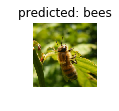

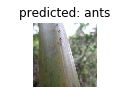

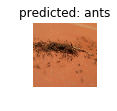

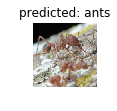

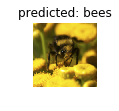

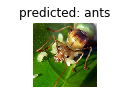

In [9]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Step 4 - Classifying for own Image

In [61]:
import requests
from PIL import Image

In [62]:
labels = "https://s3.amazonaws.com/outcome-blog/imagenet/labels.json"

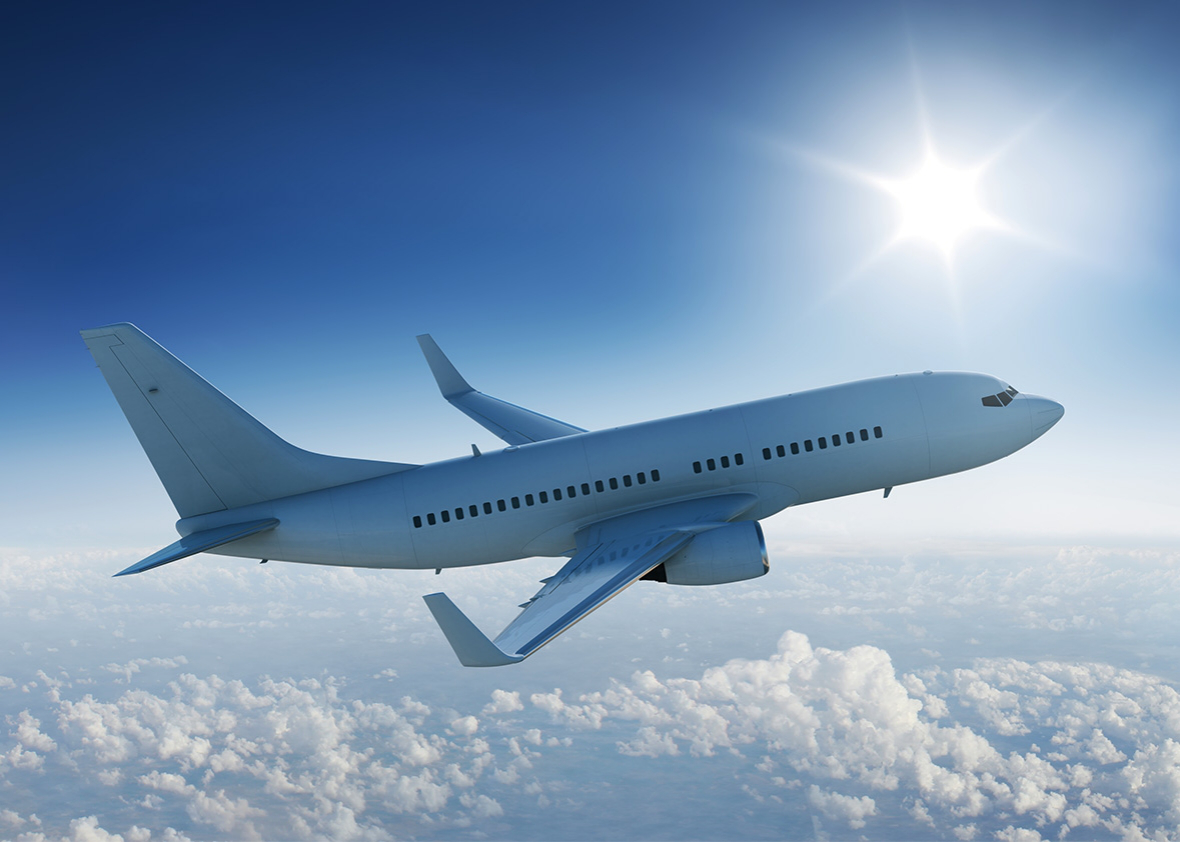

In [63]:
image = Image.open('/home/isa21/123.jpg')
image

In [64]:
preprocess = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

/opt/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [65]:
img_tensor = preprocess(image)
img_tensor.unsqueeze_(0)


( 0 , 0 ,.,.) = 
 -1.7069 -1.7069 -1.7069  ...   0.2282  0.2282  0.2282
 -1.6898 -1.6898 -1.6898  ...   0.3138  0.3138  0.2967
 -1.6898 -1.6898 -1.6898  ...   0.3823  0.3823  0.3823
           ...             â‹±             ...          
 -0.0972 -0.0801 -0.0801  ...   1.4783  1.6153  1.6324
 -0.0458 -0.0458 -0.0287  ...   1.5639  1.6495  1.7352
  0.1939  0.1426  0.1083  ...   1.5639  1.6667  1.6324

( 0 , 1 ,.,.) = 
 -1.1253 -1.1253 -1.1253  ...   0.8179  0.8179  0.8179
 -1.1078 -1.1078 -1.1078  ...   0.9055  0.9055  0.8880
 -1.1078 -1.1078 -1.1078  ...   0.9580  0.9580  0.9580
           ...             â‹±             ...          
  0.5203  0.5378  0.5378  ...   1.6758  1.7808  1.7983
  0.5203  0.5378  0.5203  ...   1.7458  1.7983  1.8683
  0.6604  0.6078  0.5903  ...   1.7108  1.7983  1.7633

( 0 , 2 ,.,.) = 
 -0.0615 -0.0615 -0.0615  ...   1.5594  1.5420  1.5420
 -0.0441 -0.0441 -0.0441  ...   1.5942  1.5942  1.5768
 -0.0441 -0.0441 -0.0441  ...   1.6291  1.6291  1.6117
       

In [66]:
labelkeyvalue = {int(key):value for (key, value)
          in requests.get(labels).json().items()}

In [67]:
model = torchvision.models.vgg19(pretrained=True)
output = model(Variable(img_tensor))
key=torch.max(output.data, 1)[1]

In [68]:
type(key)

torch.LongTensor

In [69]:
labelkeyvalue[int(key)]

'airliner'

Image classified correctly as Airliner